In [64]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import Counter
from scipy.optimize import curve_fit
import re
import os
import nltk
from nltk.corpus import stopwords

In [65]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pitta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
MAX_LONG = 20
MIN_LONG = 3
STOP_WORDS_FILE = '../stop-words.txt'
URL_QUIJOTE = "http://www.gutenberg.org/cache/epub/2000/pg2000.txt"
response = requests.get(URL_QUIJOTE)
book_content = response.text

In [67]:
def removeStopWords(words_list, stop_words_list):
    cleaned_text = [word for word in words_list if word not in stop_words_list]
    return cleaned_text

In [68]:
def findAbbreviations(content):
    REGEX_ABBREVIATIONS = r'\b[a-zA-Z][bcdfgh-np-tvxz]+(?![A-Z])\.'
    return re.findall(REGEX_ABBREVIATIONS, content)

In [69]:
def findEmailsAndUrls(content):
    REGEX_EMAILS = r'\b[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+'
    REGEX_URLS = r'(https?://)?(www\.[a-z0-9]+(?:\.[a-z0-9]+)+)'
    list_emails = re.findall(REGEX_EMAILS, content)
    list_urls = [''.join(url_tuple) for url_tuple in re.findall(REGEX_URLS, content)]
    return list_emails + list_urls

In [70]:
def findNumbersAndPhones(content):
    REGEX_NUMBERS = r' (\d+)'
    REGEX_PHONES = r'\+?\d{6,}|\+?\d{8,}|\d{2,}-\d{5,}|\+?\d+-\d{2,}-\d{5,}'
    list_numbers = re.findall(REGEX_NUMBERS, content)
    list_phones = re.findall(REGEX_PHONES, content)
    return list_phones + list_numbers

In [71]:
def findWords(content):
    REGEX_WORDS = f'[A-zÀ-ú]{{{MIN_LONG},{MAX_LONG}}}'
    return re.findall(REGEX_WORDS, content)

In [72]:
def tokenizer(content, stop_words_list = None):
    abbreviations_list = findAbbreviations(content)
    emailsAndUrls_list = findEmailsAndUrls(content)
    numbersAndPhones_list = findNumbersAndPhones(content)
    words_list = findWords(content)
    content = abbreviations_list + emailsAndUrls_list + numbersAndPhones_list + words_list
    if stop_words_list != None:
        content = removeStopWords(content, stop_words_list)
    return content

In [73]:
def loadFileStopWords(stop_words_file: str):
    complete_route = os.path.abspath(stop_words_file)
    with open(complete_route, 'r', encoding='utf-8') as file:
        stop_words = set(word.strip() for word in file.readlines())
    return stop_words

In [74]:
# Obtener la lista de términos y sus frecuencias
terms = tokenizer(book_content)
term_freq = Counter(terms)
sorted_term_freq = sorted(term_freq.items(), key=lambda x: x[1], reverse=True)
frequencies = [freq for term, freq in sorted_term_freq]

# Calcular el rango de los datos para el ajuste
rank = np.arange(1, len(frequencies) + 1)
# Ajustar la curva utilizando Polyfit
log_frequencies = np.log(frequencies)
log_rank = np.log(rank)
coefficients = np.polyfit(log_rank, log_frequencies, 1)
fit = np.poly1d(coefficients)

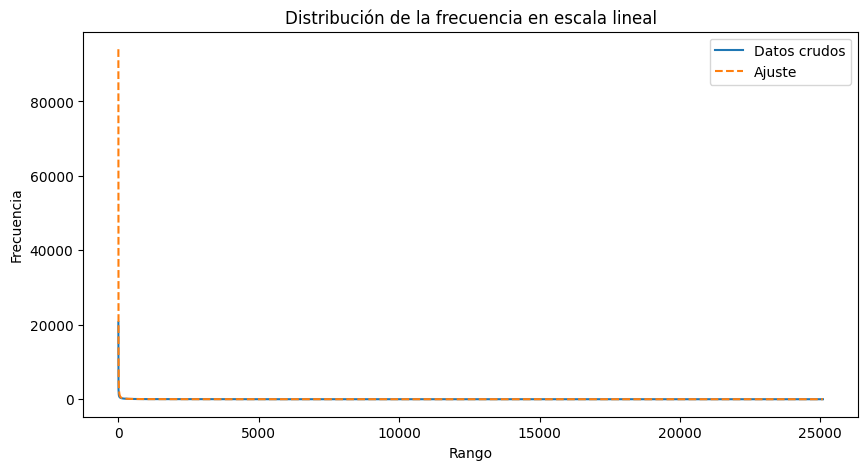

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(rank, frequencies, label='Datos crudos')
plt.plot(rank, np.exp(fit(log_rank)), label='Ajuste', linestyle='--')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.title('Distribución de la frecuencia en escala lineal')
plt.legend()
plt.show()

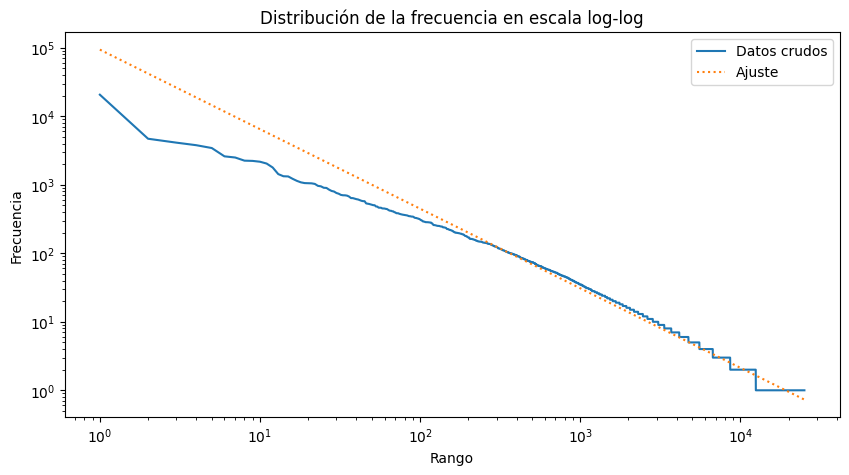

In [76]:
# Graficar los datos y el ajuste en escala log-log
plt.figure(figsize=(10, 5))
plt.loglog(rank, frequencies, label='Datos crudos')
plt.loglog(rank, np.exp(fit(log_rank)), label='Ajuste', linestyle='dotted')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.title('Distribución de la frecuencia en escala log-log')
plt.legend()
plt.show()

In [77]:
total_words = len(sorted_term_freq)
inv_fit = np.poly1d(coefficients)

# Calcular la frecuencia esperada para el 10%, 20% y 30% del vocabulario
percentages = [0.1, 0.2, 0.3]
expected_frequencies = [np.exp(inv_fit(np.log(total_words * p))) for p in percentages]

# Paso 1: Obtener la distribución real de frecuencias de palabras
real_word_freq = [freq for term, freq in sorted_term_freq]

# Paso 2: Ordenar las palabras por frecuencia
real_word_freq_sorted = sorted(real_word_freq, reverse=True)

# Paso 3: Calcular la cantidad de palabras en cada porcentaje del vocabulario
total_unique_words = len(real_word_freq_sorted)
real_words_in_percentages = [real_word_freq_sorted[int(p * total_unique_words)] for p in percentages]

# Paso 4: Comparar con los valores esperados
expected_frequencies = [round(expected) for expected in expected_frequencies]

# Paso 5: Imprimir resultados
print("Porcentaje del vocabulario\t Valor esperado\t Valor real")
for i, p in enumerate(percentages):
    print(f"{p*100}% \t\t\t\t {expected_frequencies[i]}\t\t {real_words_in_percentages[i]}")


Porcentaje del vocabulario	 Valor esperado	 Valor real
10.0% 				 11		 12
20.0% 				 5		 5
30.0% 				 3		 3


In [78]:
pruned_vocab = {}
for p in percentages:
    cutoff = int(len(sorted_term_freq) * p)
    pruned_terms = [term for term, freq in sorted_term_freq[:cutoff]]
    pruned_vocab[p] = pruned_terms

percentage_empty_words = {}
for p, terms in pruned_vocab.items():
    empty_words_count = sum(1 for term in terms if term in stop_words)
    percentage_empty_words[p] = empty_words_count / len(terms) * 100

print("Porcentaje del vocabulario\t Porcentaje de palabras vacías")
for p in percentages:
    print(f"{p*100}% \t\t\t\t {percentage_empty_words[p]}%")


Porcentaje del vocabulario	 Porcentaje de palabras vacías
10.0% 				 6.3371861299322445%
20.0% 				 3.8860103626943006%
30.0% 				 2.776670652318321%


In [79]:
important_words = {}
for p, terms in pruned_vocab.items():
    important_words[p] = [term for term in terms if term not in stop_words]
for p, words in important_words.items():
    print(f"Palabras podadas en el {p*100}% del vocabulario que no son stopwords:")
    print(words)


Palabras podadas en el 10.0% del vocabulario que no son stopwords:
['don', 'Quijote', 'Sancho', 'dijo', 'tan', 'ser', 'respondió', 'bien', 'señor', 'así', 'merced', 'sino', 'dos', 'pues', 'caballero', 'decir', 'hacer', 'aunque', 'Dios', 'señora', 'aquel', 'aquí', 'mal', 'cosa', 'buen', 'tal', 'verdad', 'ver', 'allí', 'mundo', 'alguna', 'dicho', 'dar', 'parte', 'cosas', 'todas', 'buena', 'vida', 'luego', 'Panza', 'menos', 'lugar', 'casa', 'manera', 'aquella', 'tiempo', 'gran', 'toda', 'cura', 'ahora', 'puesto', 'mano', 'amo', 'dio', 'caballeros', 'ojos', 'Dulcinea', 'puede', 'visto', 'algún', 'mejor', 'día', 'tierra', 'historia', 'padre', 'hombre', 'hecho', 'Pero', 'haber', 'quiero', 'cielo', 'aun', 'digo', 'amigo', 'saber', 'vio', 'escudero', 'camino', 'tener', 'fin', 'manos', 'parece', 'días', 'cómo', 'muchas', 'hizo', 'desta', 'tres', 'Pues', 'mujer', 'cuenta', 'quién', 'cuanto', 'mesmo', 'cabeza', 'dice', 'cada', 'punto', 'noche', 'veces', 'replicó', 'Rocinante', 'razones', 'parecer